In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
%matplotlib inline

from matplotlib import rcParams
import matplotlib as mpl
import random

In [2]:
from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set_style("darkgrid")
sns.set_context("poster")

In [977]:
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve,precision_recall_curve, precision_score, confusion_matrix, classification_report

In [3]:
# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [953]:
opioids = pd.read_csv('opioids.csv')
overdoses = pd.read_csv('overdoses.csv', thousands = ',')
prescriber = pd.read_csv('prescriber_cap.csv')

In [954]:
overdoses= overdoses[['Abbrev', 'Population']]

In [955]:
#Merge Overdoses DF on Prescriber DF
prescriber = pd.merge(prescriber, overdoses, on=['Abbrev'], how='outer')

## Regression Analysis

In [956]:
df = prescriber[['Gender', 'Abbrev', 'Specialty', 'Population', 'SumOpi', 'NonOpi']]

In [958]:
df.rename(columns={'Abbrev': 'State'}, inplace=True)

We will pre-process the categorical variables by converting their values to discrete integers which makes it easier to handle for modeling algorithms. This is done using the LabelEncoder function of the sklearn machine learning library in Python.

In [959]:
df

,Gender,State,Specialty,Population,SumOpi,NonOpi
0,M,TX,Dentist,26448193,17,12
1,M,TX,Optometry,26448193,0,144
2,M,TX,General Surgery,26448193,17,0
3,F,TX,Hematology/Oncology,26448193,155,579
4,M,TX,Urology,26448193,132,1090
...,...,...,...,...,...,...
24754,M,SD,Optometry,844877,0,223
24755,F,SD,Nurse Practitioner,844877,0,1322
24756,M,SD,Physician Assistant,844877,66,1125
24757,F,SD,Physician Assistant,844877,0,24


In [960]:
rich = df[df['SumOpi'] >= 1]
print('Number of Opoiods Prescribed: ', len(rich))
rich = df[df['SumOpi'] <= 1]
print('Number of non-Opoiods Prescribed: ', len(rich))

Number of Opoiods Prescribed:  12688
Number of non-Opoiods Prescribed:  12071


In [969]:
data = df

fit_spec = ols('NonOpi ~ C(Gender) + C(State) + C(Specialty) + SumOpi', data).fit()

model = fit_spec.summary()

HTML(
(model
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

In [974]:
data = df

m_1 = ols('NonOpi ~ C(Gender) + C(State) + C(Specialty) + SumOpi', data).fit()

model = m_1

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 NonOpi   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     111.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:46:32   Log-Likelihood:            -2.2622e+05
No. Observations:               24759   AIC:                         4.528e+05
Df Residuals:                   24600   BIC:                         4.541e+05
Df Model:                         158                                         
Covariance Type:            nonrobust                                         
                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

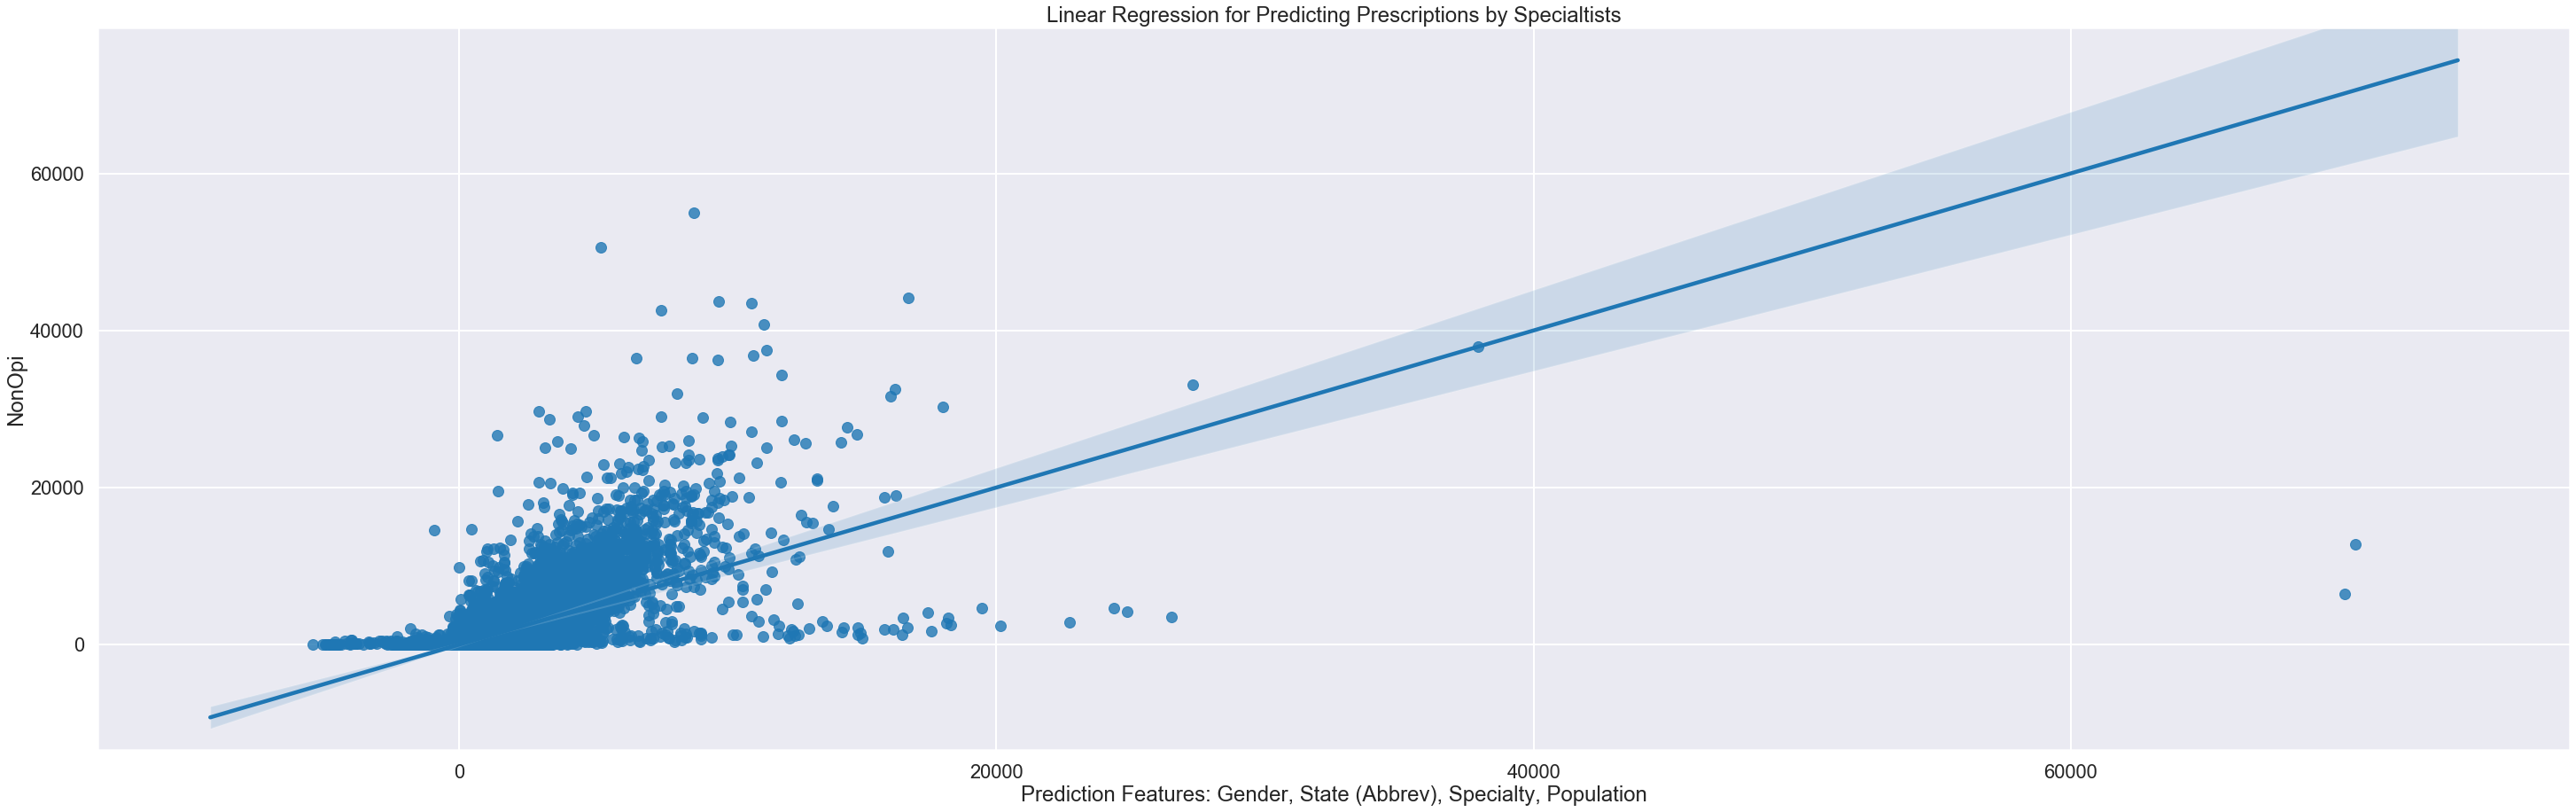

In [975]:
import random

plt.ion()

plt.figure(figsize = (50,15))
sns.regplot(x = model.fittedvalues, y = 'NonOpi', data = data, fit_reg = True)
          
ax = plt.gca()

# recompute the ax.dataLim
ax.relim()
# update ax.viewLim using the new dataLim
ax.autoscale_view()
plt.ylabel('NonOpi')
plt.xlabel('Prediction Features: Gender, State (Abbrev), Specialty, Population')
plt.title('Linear Regression for Predicting Prescriptions by Specialtists')
plt.draw()

In [976]:
# create a variable so we can compare our rsquared results
ols_rsq = model.rsquared
ols_rsq

0.41821506646852147

## Random Forest Regression

In [978]:
df_get = pd.get_dummies(df, drop_first=True)
df_get

,Population,SumOpi,NonOpi,Gender_M,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,...,Specialty_Sports Medicine,Specialty_Student in an Organized Health Care Education/Training Program,Specialty_Surgery,Specialty_Surgical Oncology,Specialty_Thoracic Surgery,Specialty_Thoracic Surgery (Cardiothoracic Vascular Surgery),Specialty_Unknown Physician Specialty Code,Specialty_Unknown Supplier/Provider,Specialty_Urology,Specialty_Vascular Surgery
0,26448193,17,12,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26448193,0,144,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26448193,17,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26448193,155,579,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26448193,132,1090,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,844877,0,223,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24755,844877,0,1322,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24756,844877,66,1125,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24757,844877,0,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [979]:
data = df_get.fillna(0)

y = data.NonOpi
# drop inconsequential features
X = data.drop('NonOpi', axis=1)  # drop NonOpi as it is our prediction feature

In [988]:
data

,Population,SumOpi,NonOpi,Gender_M,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,...,Specialty_Sports Medicine,Specialty_Student in an Organized Health Care Education/Training Program,Specialty_Surgery,Specialty_Surgical Oncology,Specialty_Thoracic Surgery,Specialty_Thoracic Surgery (Cardiothoracic Vascular Surgery),Specialty_Unknown Physician Specialty Code,Specialty_Unknown Supplier/Provider,Specialty_Urology,Specialty_Vascular Surgery
0,26448193,17,12,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26448193,0,144,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26448193,17,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26448193,155,579,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26448193,132,1090,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,844877,0,223,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24755,844877,0,1322,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24756,844877,66,1125,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24757,844877,0,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [980]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

Model R-squared: 0.622


In [981]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

,feature,importance,rank
1,SumOpi,0.623821,1
92,Specialty_Internal Medicine,0.074695,2
75,Specialty_Family Practice,0.064430,3
0,Population,0.030499,4
58,Specialty_Cardiology,0.022705,5
2,Gender_M,0.016228,6
10,State_FL,0.011431,7
43,State_TN,0.008599,8
66,Specialty_Community Health Worker,0.008010,9
78,Specialty_General Practice,0.007492,10


## XGBoost

In [982]:
import xgboost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 3, learning_rate = 0.05) 
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [989]:
model.predict(X_test)

xgb_rsq = model.score(X_test, y_test)
xgb_rsq

0.6463289481158616

In [984]:
#for tuning parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [993]:
parameters_for_testing = {
    'min_child_weight':[1,2,3],
    'learning_rate':[0.1,0.07,0.05],
    'max_depth':[3,5],
}

                    
xgb_model = xgboost.XGBRegressor(objective = 'reg:squarederror', learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=15)

gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, 
                        n_jobs=6,iid=False, verbose=10,scoring='r2')
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 30.6min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 36.4min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 47.2min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 58.7min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 70.0min
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed: 86.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_e...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    seed=15, subsample=0.8, tree_method=None,
    

In [994]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3}
best score
0.6461053853866356


In [995]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23)

model = xgboost.XGBRegressor(objective='reg:squarederror',
                             max_depth=5, learning_rate=0.05, min_child_weight=2)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [996]:
xgb_feature_importances = pd.DataFrame({'feature': X.columns,
                                        'importance': model.feature_importances_}).sort_values('importance',
                                                                                               ascending=False)
xgb_feature_importances.head(10)

,feature,importance
92,Specialty_Internal Medicine,0.129878
75,Specialty_Family Practice,0.126708
1,SumOpi,0.113927
58,Specialty_Cardiology,0.051363
78,Specialty_General Practice,0.036421
80,Specialty_Geriatric Medicine,0.031011
120,Specialty_Orthopedic Surgery,0.029520
8,State_CT,0.028109
15,State_IL,0.025456
69,Specialty_Dentist,0.024744


C:\Users\Jimsyd\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



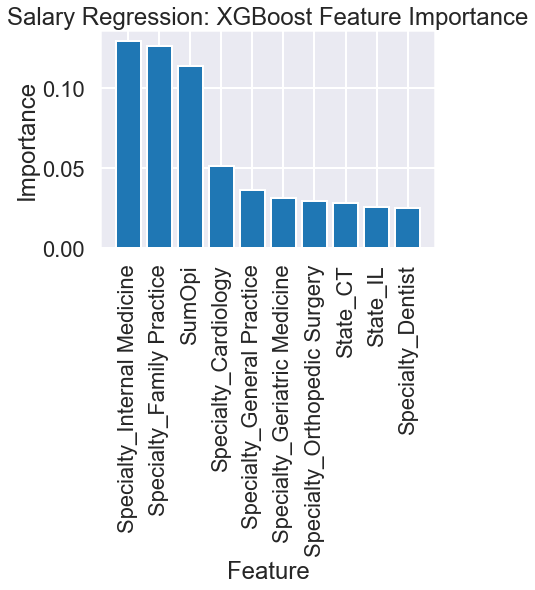

In [997]:
plt.bar(xgb_feature_importances.feature[:10], xgb_feature_importances.importance[:10])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(xgb_feature_importances.feature[:10], rotation = 90)
plt.title('Salary Regression: XGBoost Feature Importance')
plt.show()

In [998]:
model.predict(X_test)

xgb_rsq = model.score(X_test, y_test)
xgb_rsq

0.6463289481158616

In [ ]:
## Comparing Models

In [999]:
regressor_models = pd.DataFrame({'name':['OLS Regression','Random Forest','XGBoost'],
                                 'R-squared':[ols_rsq,rf_rsq, xgb_rsq]})
regressor_models

,name,R-squared
0,OLS Regression,0.418215
1,Random Forest,0.622078
2,XGBoost,0.646329


XGBoost is our highest but overall, our models don't really give us an impressive score. To better the score we'd need to add more features. These models tried tp predict if a specialist would prescribe an opioid to their patients.

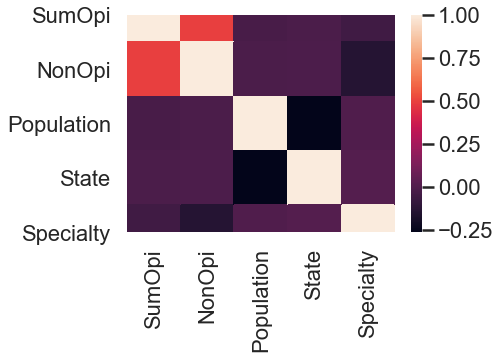

In [1006]:
sns.heatmap(df_corr[['SumOpi', 'NonOpi', 'Population', 'State', 'Specialty']].corr())

In [1007]:
df_corr.corr()

,Gender,State,Specialty,Population,SumOpi,NonOpi
Gender,1.000000,-0.009391,-0.144758,0.014512,0.070431,0.081921
State,-0.009391,1.000000,0.015114,-0.262505,-0.013677,-0.009955
Specialty,-0.144758,0.015114,1.000000,0.000354,-0.049456,-0.138387
Population,0.014512,-0.262505,0.000354,1.000000,-0.024287,-0.014383
SumOpi,0.070431,-0.013677,-0.049456,-0.024287,1.000000,0.493554
NonOpi,0.081921,-0.009955,-0.138387,-0.014383,0.493554,1.000000


## Clustering

In [310]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

In [705]:
df_new = prescriber[['NPI', 'Specialty', 'Spec_group']]
df_call = prescriber[['NPI', 'Abbrev', 'Region', 'Opioid_Prescriber', 'Population', 'Gender', 'SumOpi']]

In [708]:
df_new['N'] = 1

C:\Users\Jimsyd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [709]:
df_merge = pd.merge(df_new, df_call, how='left', on='NPI')

### Clustering with Specialty and SumOpi columns (SumOpi = total sum of opioids prescribed per specialists)

In [710]:
df_pivot = df_merge.pivot_table(index='Specialty', columns='SumOpi', values='N').fillna(0)

In [711]:
df_pivot

SumOpi,0,11,12,13,14,15,16,17,18,19,...,4283,4473,4687,4941,5021,5793,5890,6003,14674,15234
Specialty,,,,,,,,,,,,,,,,,,,,,
Addiction Medicine,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Allergy/Immunology,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anesthesiology,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
Behavioral Analyst,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRNA,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thoracic Surgery (Cardiothoracic Vascular Surgery),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Physician Specialty Code,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Supplier/Provider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [712]:
df_merge

,NPI,Specialty,Spec_group,N,Abbrev,Region,Opioid_Prescriber,Population,Gender,SumOpi
0,1710982582,Dentist,group1,1,TX,South,1,26448193,M,17
1,1023260569,Optometry,group1,1,TX,South,0,26448193,M,0
2,1659334472,General Surgery,group1,1,TX,South,1,26448193,M,17
3,1952598419,Hematology/Oncology,group1,1,TX,South,1,26448193,F,155
4,1043399322,Urology,group1,1,TX,South,1,26448193,M,132
...,...,...,...,...,...,...,...,...,...,...
24754,1841302700,Optometry,group1,1,SD,Central,0,844877,M,0
24755,1336293323,Nurse Practitioner,group1,1,SD,Central,0,844877,F,0
24756,1851630727,Physician Assistant,group1,1,SD,Central,1,844877,M,66
24757,1447239942,Physician Assistant,group1,1,SD,Central,0,844877,F,0


In [713]:
x_cols = df_pivot.values
x_cols[:5,:]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [714]:
model = KMeans(n_clusters = 5, random_state = 0)
model.fit(x_cols)

print(model.labels_)
print(model.cluster_centers_)
print(model.inertia_)

[4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 0 0 4 1 4 4 3 0 4 0 1 4 4 4 4 4 4 1 4
 4 4 4 0 2 4 4 4 4 4 4 4 4 0 4 4 4 4 0 4 0 4 4 0 4 1 0 0 4 4 0 4 1 4 0 4 4
 4 4 4 0 4 1 4 0 0 4 4 0 4 4 4 0 0 4 4 0 4 4 4 4 4 0 4 4 4 4 4 4 0 0]
[[ 1.00000000e+00  9.58333333e-01  8.75000000e-01 ...  5.20417043e-18
   4.16666667e-02  5.20417043e-18]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.07894737e-01  2.50000000e-01  3.02631579e-01 ...  1.31578947e-02
  -5.20417043e-18  1.31578947e-02]]
1948.3793859649127


In [644]:
model.predict(x_cols)

array([4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 1,
       4, 4, 3, 0, 4, 0, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 0, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 0, 4, 4, 0, 4, 1, 0, 0, 4,
       4, 0, 4, 1, 4, 0, 4, 4, 4, 4, 4, 0, 4, 1, 4, 0, 0, 4, 4, 0, 4, 4,
       4, 0, 0, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0])

In [645]:
ks = np.arange(1,11)
SS = []

for k in ks:
    model = KMeans(n_clusters = k, random_state = 10)
    model.fit(x_cols)
    SS.append(model.inertia_)

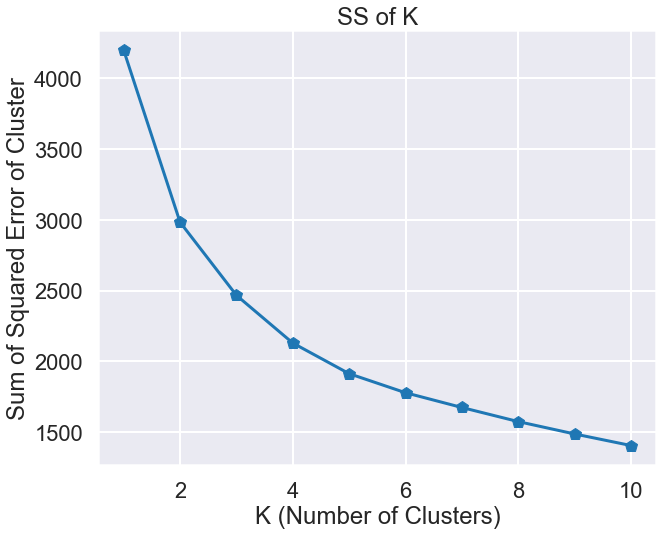

In [646]:
#Plot SS of k
plt.figure(figsize=(10,8))
plt.plot(ks, SS, marker= 'p')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Sum of Squared Error of Cluster')
plt.title('SS of K')
plt.show()

Text(0.5, 0, 'Cluster')

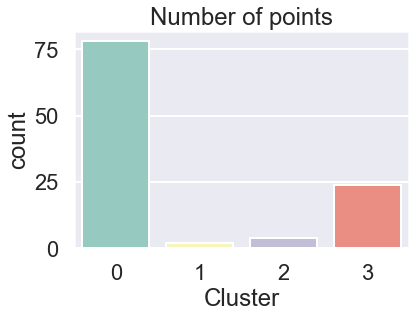

In [715]:
# Training kmeans model with the best K of 4
model_knm = KMeans(n_clusters= 4, random_state = 10).fit(x_cols)

sns.countplot(model_knm.labels_, palette = "Set3" )
plt.title("Number of points")
plt.xlabel('Cluster')

For n_clusters = 2 The average silhouette score is : 0.6689433367689573
For n_clusters = 3 The average silhouette score is : 0.5248899074341239
For n_clusters = 4 The average silhouette score is : 0.4101433504414239
For n_clusters = 5 The average silhouette score is : 0.4089643439081989
For n_clusters = 6 The average silhouette score is : 0.4091514909085612
For n_clusters = 7 The average silhouette score is : 0.38909111762997317
For n_clusters = 8 The average silhouette score is : 0.38035779879735154
For n_clusters = 9 The average silhouette score is : 0.38173923906914253
For n_clusters = 10 The average silhouette score is : 0.39007270829007074


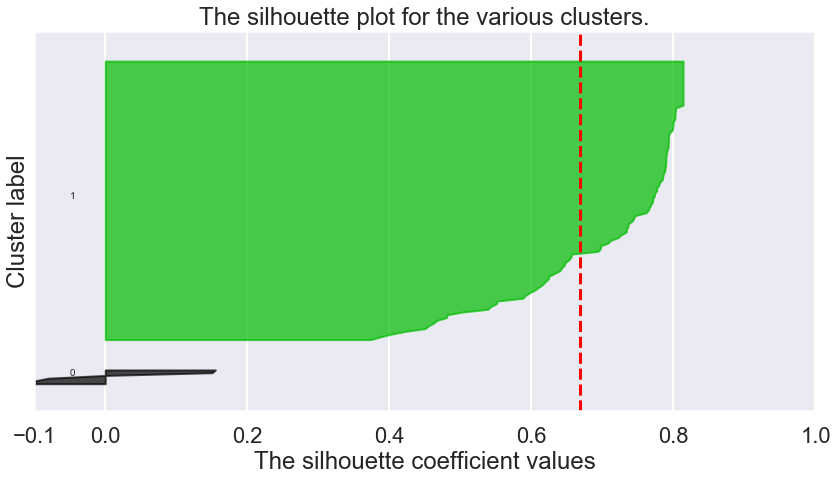

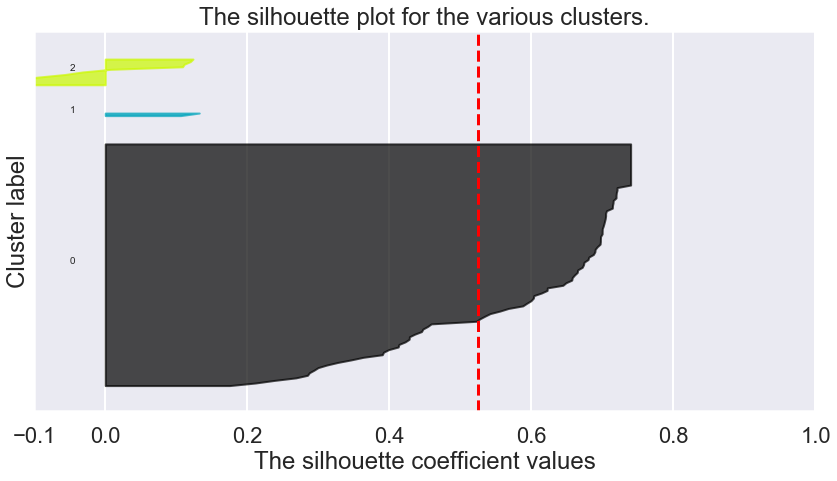

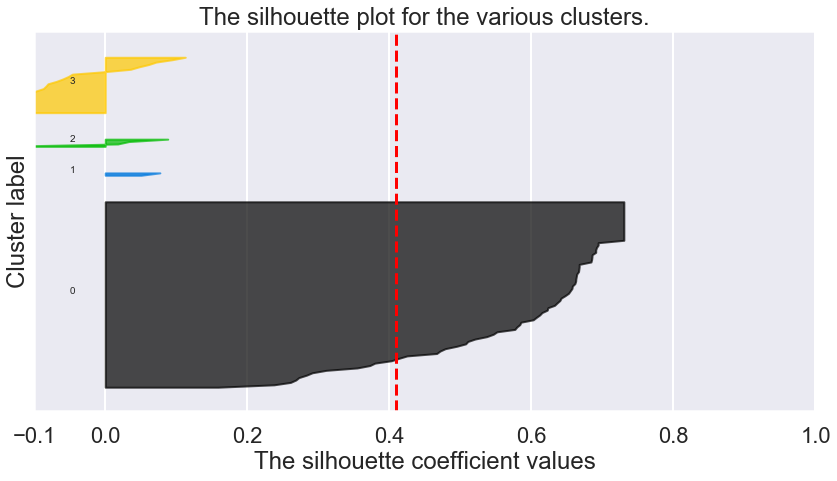

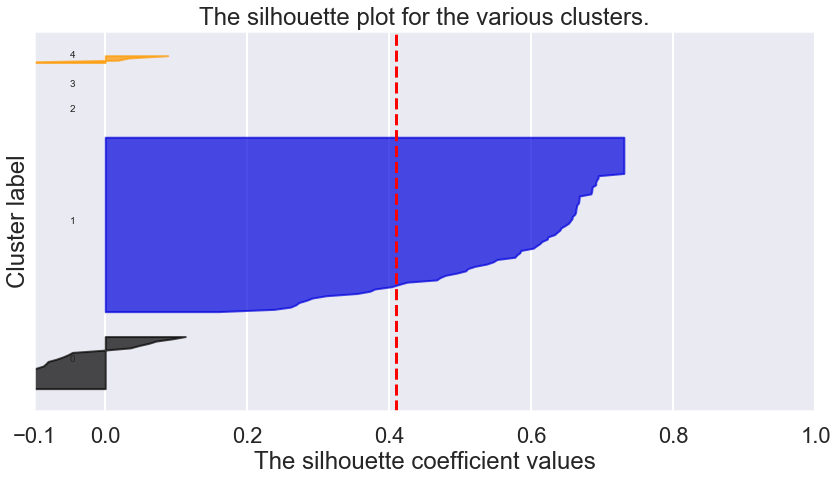

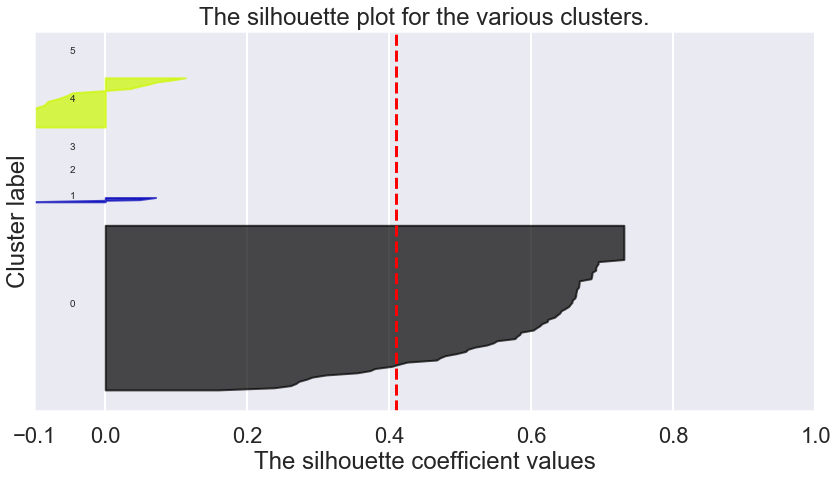

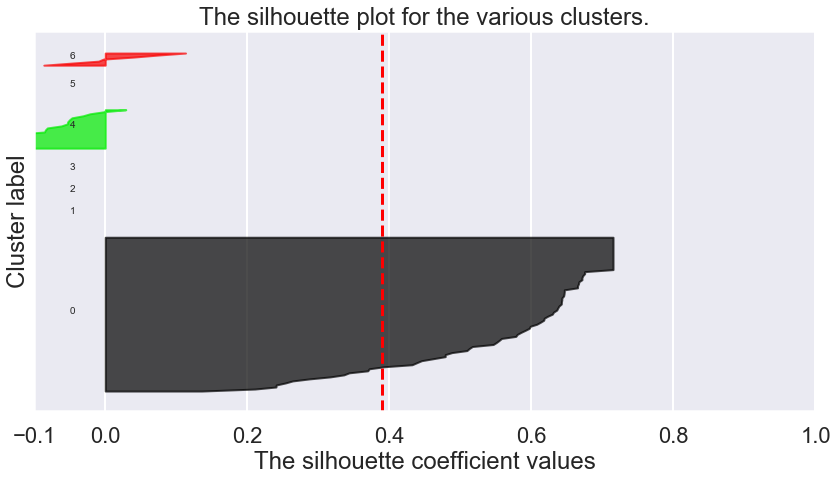

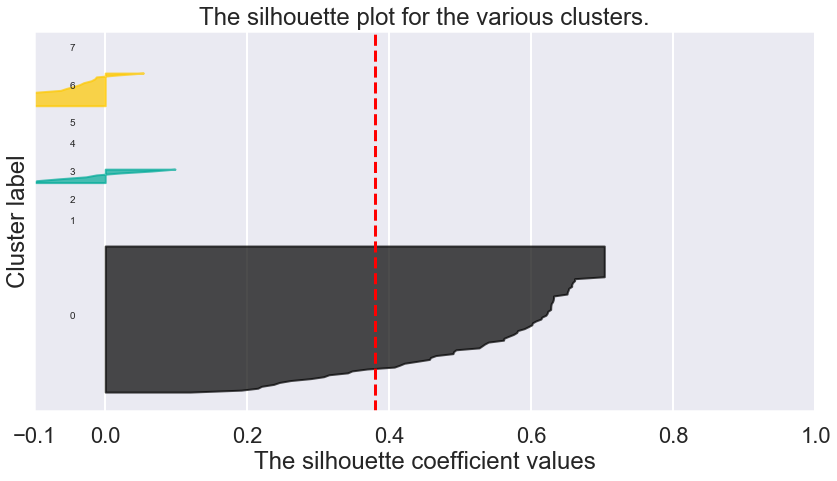

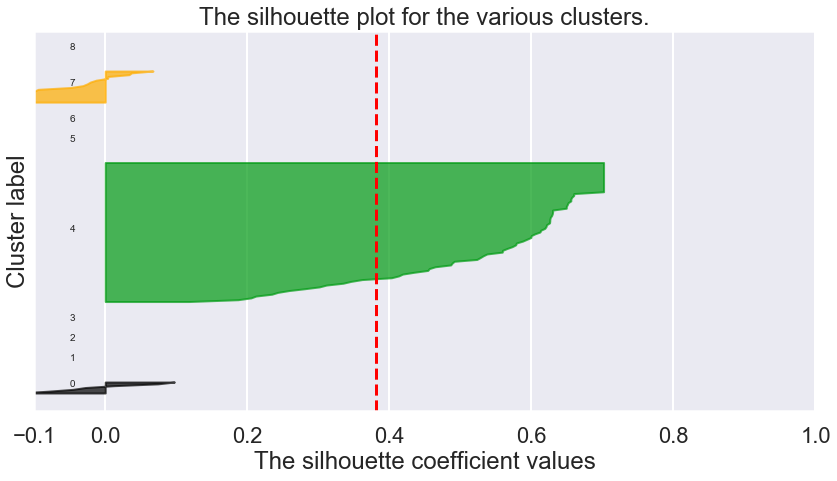

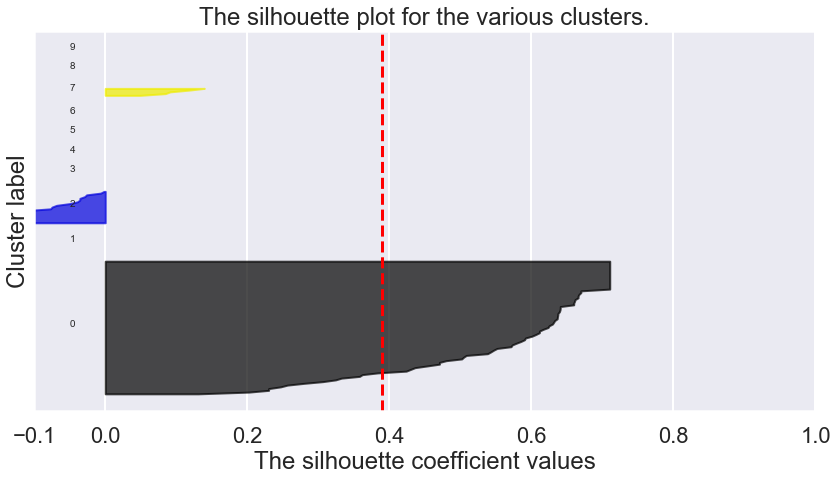

In [716]:
range_n_clusters = np.arange(2,11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    #Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(14,7)
    
    #1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    
    #Initialize the cluster with n_clusters value and random state of 10
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    #Average value for all samples through silhouette_score
    sil_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_scores.append(sil_avg)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette score is :", sil_avg)
    
    #Silhouette score of each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        # Sort scores for samples of cluster i 
        ith_cluster_silhouette_values.sort()
        
        # Obtain shape to add with y_lower scaling for y
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
     # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

plt.show()

Text(0.5, 1.0, 'Average Silhouette Scores for $k$')

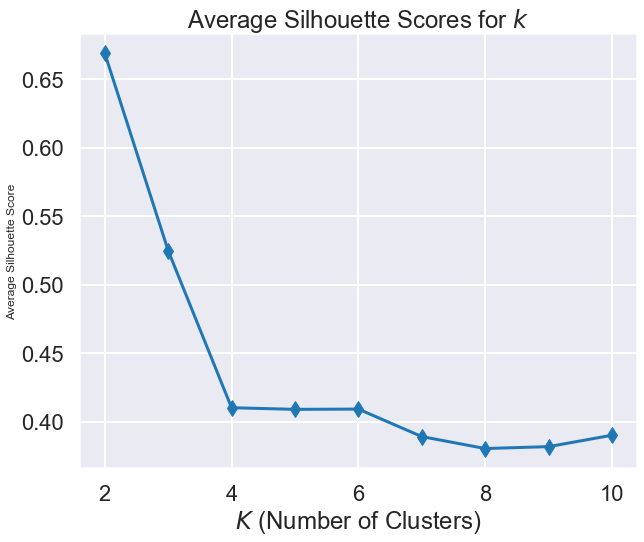

In [717]:
# Plot the Silhouette score for k = 2-10 clusters
plt.figure(figsize=(10,8))
plt.plot(range_n_clusters,silhouette_scores, marker='d')
plt.xlabel('$K$ (Number of Clusters)')
plt.ylabel('Average Silhouette Score', size = 12)
plt.title('Average Silhouette Scores for $k$')

## Visualizing Clusters using PCA

In [718]:
#Using the PCA function to reduce the dimensionality of clustering to 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(x_cols)

model = KMeans(n_clusters=6, random_state=10)
labels = model.fit(x_cols).labels_

model_2 = KMeans(n_clusters=3, random_state=10)
labels_2 = model_2.fit(x_cols).labels_

df_pca = pd.DataFrame()
df_pca['Specialty'] = df_pivot.index
df_pca['Cluster_1'] = labels
df_pca['Cluster_2'] = labels_2
df_pca['x'] = components[:,0]
df_pca['y'] = components[:,1]

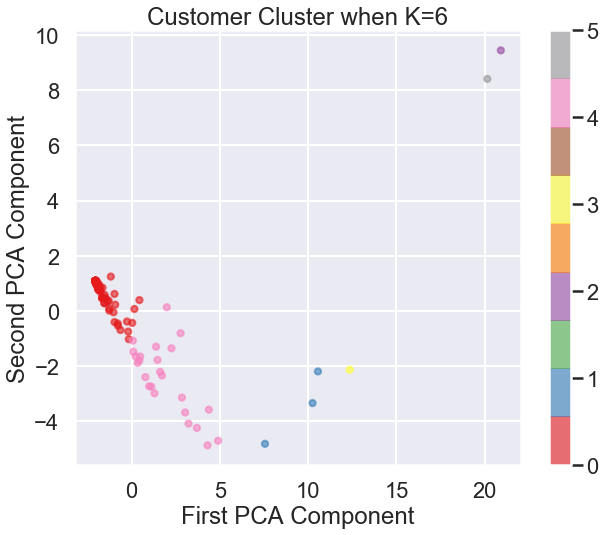

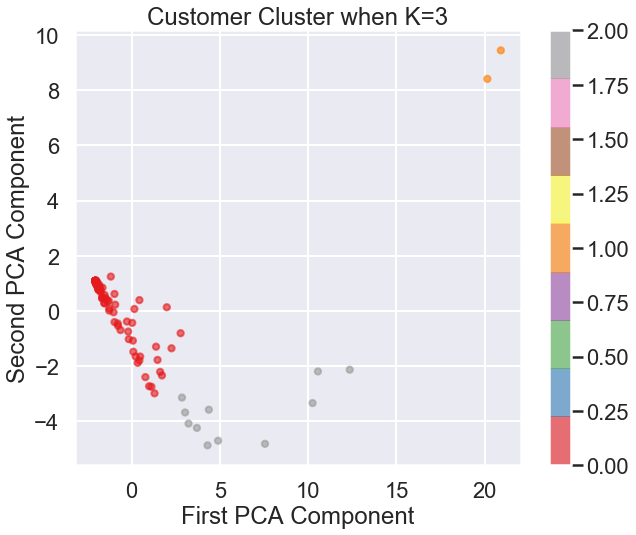

In [651]:
#plot x and y
plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, c=df_pca.Cluster_1, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=6')
plt.colorbar()
plt.plot()

plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, c=df_pca.Cluster_2, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=3')
plt.colorbar()
plt.plot();

***$K$=3 and $K$=6 seem to both have closer clusters with some outliers***

In [719]:
#Create merged DataFrame
df_main = pd.merge(df_merge, df_pca, on='Specialty')
df_main.sort_values('Cluster_2').head()

,NPI,Specialty,Spec_group,N,Abbrev,Region,Opioid_Prescriber,Population,Gender,SumOpi,Cluster_1,Cluster_2,x,y
24758,1720095482,Unknown Supplier/Provider,group4,1,ND,Central,1,723393,M,24,0,0,-2.003162,1.001359
17626,1063470250,Dermatology,group1,1,AL,South,0,4833722,F,0,4,0,0.224853,-1.648549
17627,1356639934,Dermatology,group1,1,NY,North East,0,19651127,F,0,4,0,0.224853,-1.648549
17628,1609956598,Dermatology,group1,1,NY,North East,0,19651127,M,0,4,0,0.224853,-1.648549
17629,1215014683,Dermatology,group1,1,NY,North East,0,19651127,F,0,4,0,0.224853,-1.648549


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

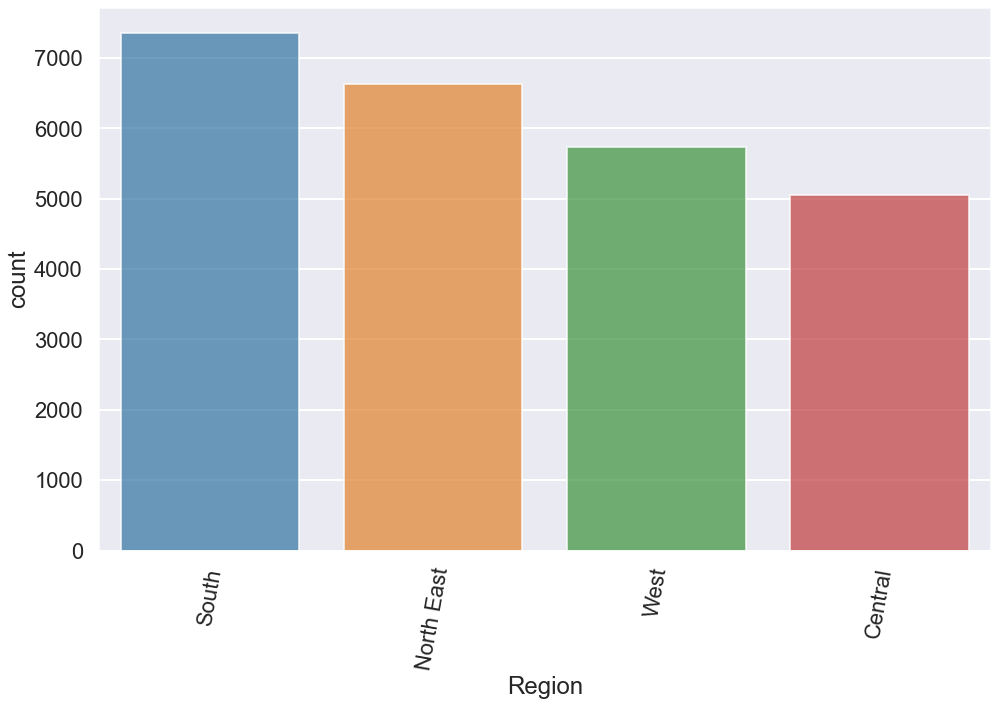

In [653]:
plt.figure(figsize=(16,10))
sns.countplot(x='Region',data=df_main,alpha=0.7)
plt.xticks(rotation=80)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

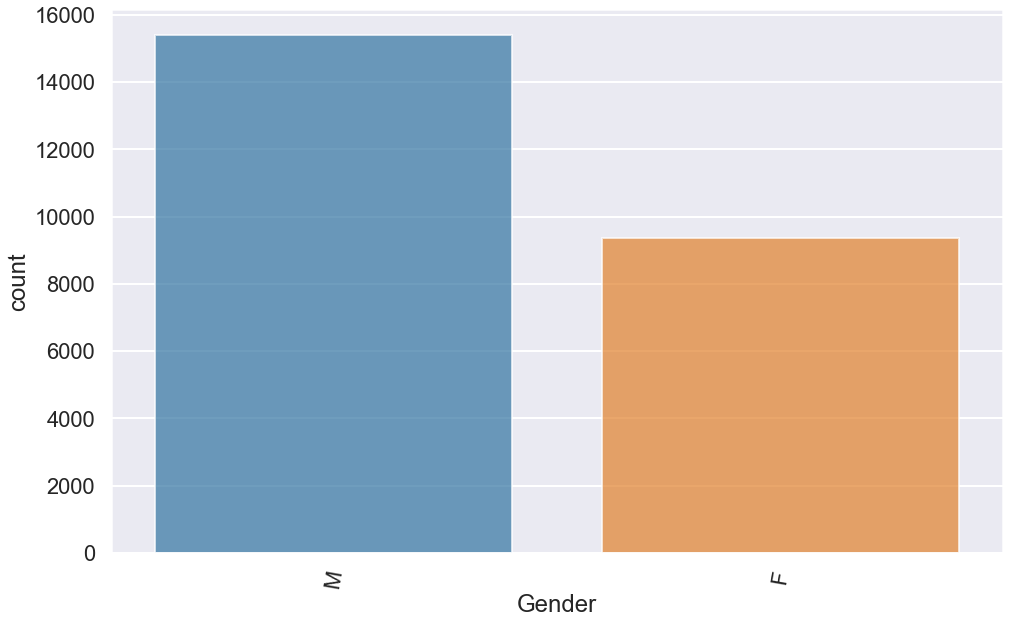

In [737]:
plt.figure(figsize=(16,10))
sns.countplot(x='Gender', data=df_main,alpha=0.7)
plt.xticks(rotation=80)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

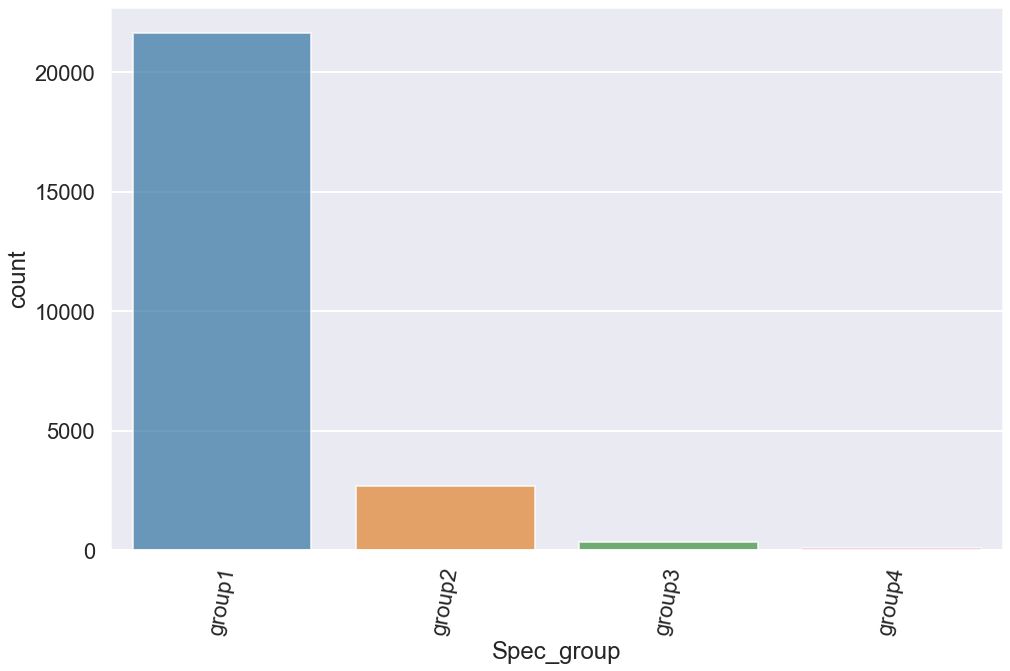

In [738]:
plt.figure(figsize=(16,10))
sns.countplot(x='Spec_group', data=df_main,alpha=0.7)
plt.xticks(rotation=80)

[]

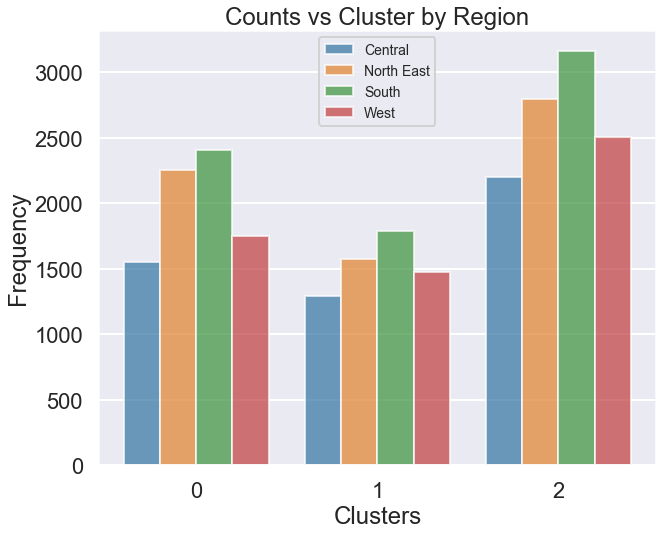

In [689]:
clust_group = df_main.groupby(['Cluster_2', 'Region']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group, hue='Region', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Region')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

Each cluster seemed to have a have the same components leading the clusters. Group1 for Specialties is mostly made up of the specialsts who have higher opioid prescriptions given. In regards to the Regions, the states located in the South lead the way in the various clusters as well.

[]

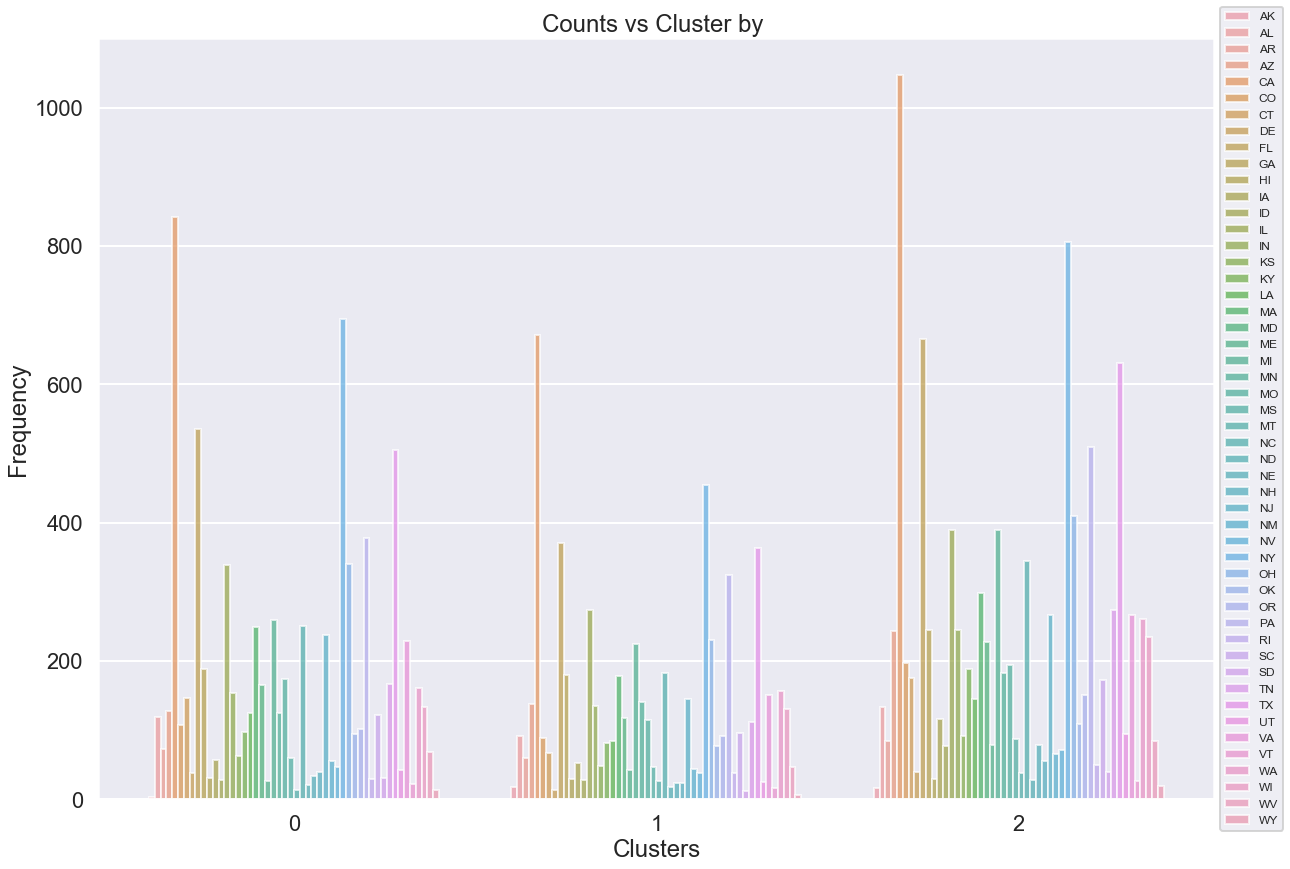

In [728]:
clust_group1 = df_main.groupby(['Cluster_2', 'Abbrev']).Specialty.count().reset_index()

plt.figure(figsize=(20,14))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group1, hue='Abbrev', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by ')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.plot()

[]

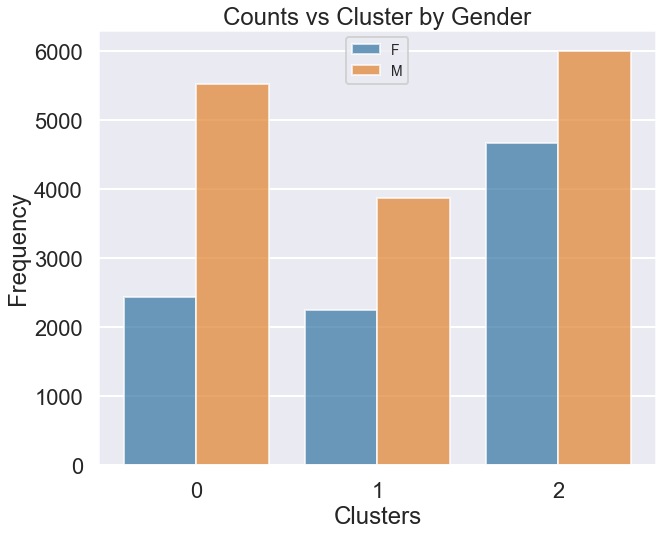

In [702]:
clust_group11 = df_main.groupby(['Cluster_2', 'Gender']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group11, hue='Gender', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Gender')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

[]

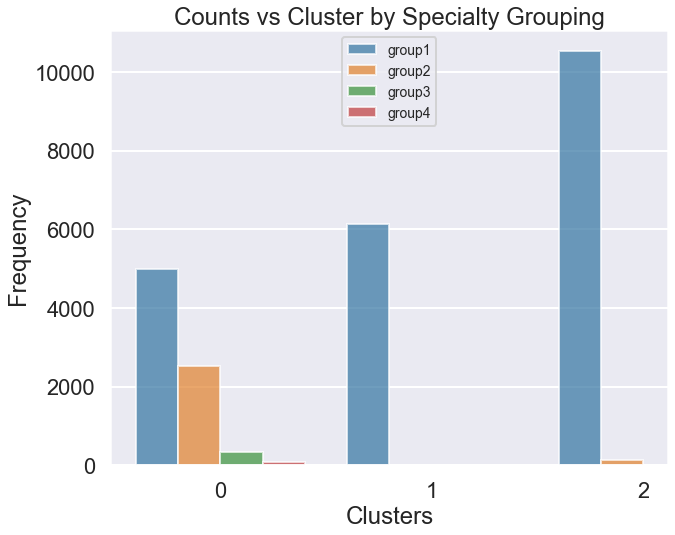

In [701]:
clust_group12 = df_main.groupby(['Cluster_2', 'Spec_group']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group12, hue='Spec_group', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Specialty Grouping')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

(0, 10)

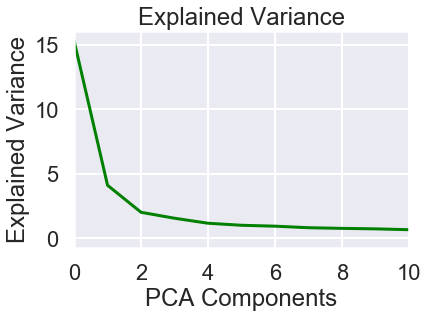

In [659]:
# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.plot(pca.explained_variance_, c='g', linewidth=3)
plt.title('Explained Variance')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance')
plt.xlim([0, 10])

The elbow curve looks to be at 1

### Other Clustering Algorithms

In [831]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
algorithms = ['AffinityPropagation', 'SpectralClustering', 'AgglomerativeClustering', 'DBSCAN']
algorithm_silscores = pd.Series(index=algorithms)

In [833]:
#Affinity Propagation (x_cols)

#find the best value for damping parameter. 
dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0.0
for damping in dampings:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For damping =", damping,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_damping = damping
        
print('Best damping parameter:', best_damping)
algorithm_silscores.loc['AffinityPropagation'] = best_score

For damping = 0.5 The average silhouette_score is : 0.21014605803802652
For damping = 0.6 The average silhouette_score is : 0.21014605803802652
For damping = 0.7 The average silhouette_score is : -0.25396501746883904
For damping = 0.8 The average silhouette_score is : 0.36262784018379857
For damping = 0.9 The average silhouette_score is : 0.36262784018379857
Best damping parameter: 0.8


In [848]:
#Spectral Clustering (x_cols)

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores.loc['SpectralClustering2'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.7419587644439746
For n_clusters = 3 The average silhouette_score is : 0.73486682160799


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)


For n_clusters = 4 The average silhouette_score is : 0.73486682160799
For n_clusters = 5 The average silhouette_score is : 0.73486682160799


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  n_init=n_init)


For n_clusters = 6 The average silhouette_score is : 0.73486682160799
For n_clusters = 7 The average silhouette_score is : 0.73486682160799


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  n_init=n_init)


For n_clusters = 8 The average silhouette_score is : 0.73486682160799
For n_clusters = 9 The average silhouette_score is : 0.73486682160799
For n_clusters = 10 The average silhouette_score is : 0.6406020248652263
Best n_clusters parameter: 2


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  n_init=n_init)


In [851]:
#Agglomerative Clustering (x_cols)

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores.loc['AgglomerativeClustering'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.7419587644439746
For n_clusters = 3 The average silhouette_score is : 0.42589301129376017
For n_clusters = 4 The average silhouette_score is : 0.4134845619598322
For n_clusters = 5 The average silhouette_score is : 0.4125525105088719
For n_clusters = 6 The average silhouette_score is : 0.39212457625310077
For n_clusters = 7 The average silhouette_score is : 0.39246507927813723
For n_clusters = 8 The average silhouette_score is : 0.39319327850974667
For n_clusters = 9 The average silhouette_score is : 0.3880016285548554
For n_clusters = 10 The average silhouette_score is : 0.37005677799160785
Best n_clusters parameter: 2


In [839]:
#DBSCAN (x_cols)

#find the best value for min_samples parameter. 
range_min_samples = [1, 2, 3]
best_score = 0.0
for min_samples in range_min_samples:
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For min_samples =", min_samples,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_min_samples = min_samples
        
print('Best min_samples parameter:',best_min_samples)
algorithm_silscores.loc['DBSCAN'] = best_score

For min_samples = 1 The average silhouette_score is : 0.19444444444444445
For min_samples = 2 The average silhouette_score is : -0.1385581028936826
For min_samples = 3 The average silhouette_score is : -0.19197235347699468
Best min_samples parameter: 1


In [844]:
print(algorithm_silscores)

AffinityPropagation        0.362628
SpectralClustering         0.741959
AgglomerativeClustering    0.741959
DBSCAN                     0.194444
dtype: float64


The clustering algorithms offer different results with Agglomerative Clustering and Spectral Clustering offering the highest silhouette score. None of the scores offer high enough scores though.

### Clustering with Specialty and NonOpi columns (NonOpi = total sum of non opioids prescribed per each specialists)

In [749]:
df_call2 = prescriber[['NPI', 'Abbrev', 'Region', 'Opioid_Prescriber', 'Population', 'Gender', 'NonOpi']]
df_merge2 = pd.merge(df_new, df_call2, how='left', on='NPI')

In [750]:
df_pivot2 = df_merge2.pivot_table(index='Specialty', columns='NonOpi', values='N').fillna(0)

In [751]:
df_pivot2

NonOpi,0,11,12,13,14,15,16,17,18,19,...,36836,37485,37919,40738,42618,43419,43702,44138,50628,54958
Specialty,,,,,,,,,,,,,,,,,,,,,
Addiction Medicine,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Allergy/Immunology,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anesthesiology,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Behavioral Analyst,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRNA,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thoracic Surgery (Cardiothoracic Vascular Surgery),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Physician Specialty Code,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Supplier/Provider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [673]:
x_cols2 = df_pivot2.values
x_cols2[:5,:]

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [674]:
model2 = KMeans(n_clusters = 5, random_state = 0)
model2.fit(x_cols2)

print(model2.labels_)
print(model2.cluster_centers_)
print(model2.inertia_)

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 2 0 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 3 0 0 0 1 0 1 0 1 0 1 1
 1 1 1 0 1 3 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1]
[[ 7.61904762e-01  9.52380952e-01  9.04761905e-01 ...  3.46944695e-18
   3.46944695e-18  3.46944695e-18]
 [ 4.93975904e-01  5.18072289e-01  4.69879518e-01 ... -8.67361738e-18
  -8.67361738e-18 -8.67361738e-18]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]]
6374.592082616181


In [675]:
ks2 = np.arange(1,11)
SS2 = []

for k in ks2:
    model2 = KMeans(n_clusters = k, random_state = 10)
    model2.fit(x_cols2)
    SS2.append(model2.inertia_)

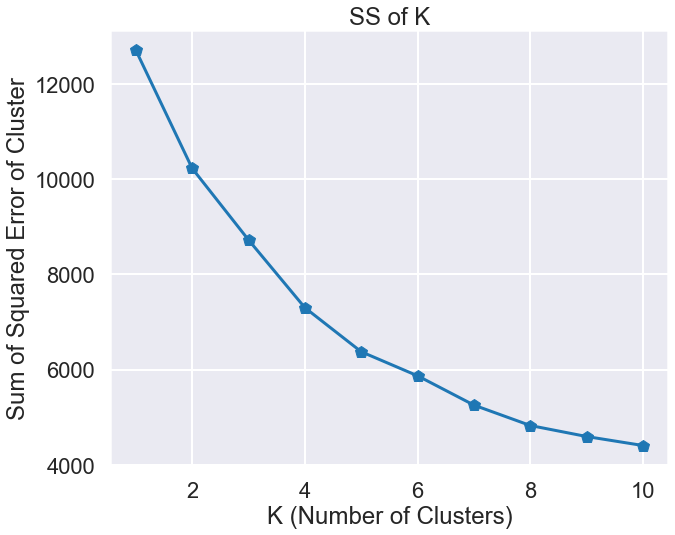

In [676]:
#Plot SS of k
plt.figure(figsize=(10,8))
plt.plot(ks2, SS2, marker= 'p')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Sum of Squared Error of Cluster')
plt.title('SS of K')
plt.show()

The challenge with the Elbow method is picking the correction location of $K$. In this case, the elbow slope wasn't pronounced enough to easily pick the proper location.

In [752]:
#Using the PCA function to reduce the dimensionality of clustering to 2 components
pca2 = PCA(n_components=2)
components2 = pca.fit_transform(x_cols2)

model2 = KMeans(n_clusters=6, random_state=10)
labels2 = model.fit(x_cols).labels_

model_2_non = KMeans(n_clusters=3, random_state=10)
labels_2_non = model_2.fit(x_cols).labels_

df_pca2 = pd.DataFrame()
df_pca2['Specialty'] = df_pivot2.index
df_pca2['Cluster_1'] = labels2
df_pca2['Cluster_2'] = labels_2_non
df_pca2['x'] = components[:,0]
df_pca2['y'] = components[:,1]

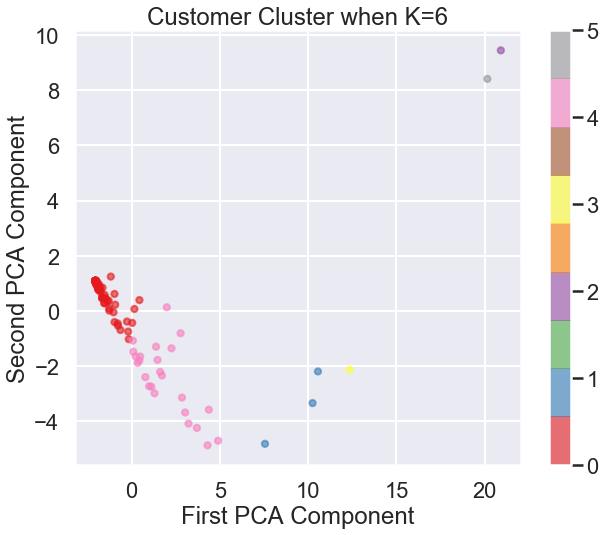

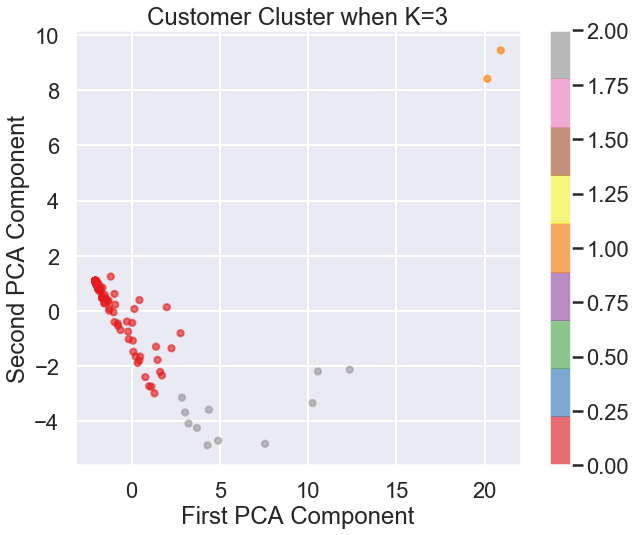

In [753]:
#plot x and y
plt.figure(figsize=(10,8))
plt.scatter(df_pca2.x, df_pca2.y, c=df_pca2.Cluster_1, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=6')
plt.colorbar()
plt.plot()

plt.figure(figsize=(10,8))
plt.scatter(df_pca2.x, df_pca2.y, c=df_pca2.Cluster_2, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=3')
plt.colorbar()
plt.plot();

***$K$=3 seems and $K$=6 seem to both have closer clusters with some outliers***

Text(0.5, 0, 'Cluster')

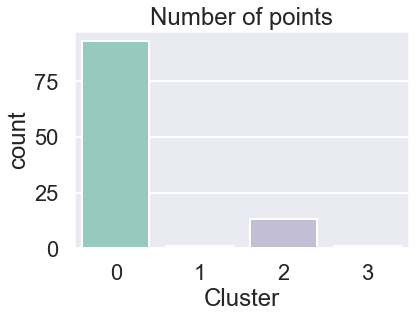

In [754]:
# Training kmeans model with the best K of 4
model_knm2 = KMeans(n_clusters= 4, random_state = 10).fit(x_cols2)

sns.countplot(model_knm2.labels_, palette = "Set3" )
plt.title("Number of points")
plt.xlabel('Cluster')

For n_clusters = 2 The average silhouette score is : 0.7090971040286691
For n_clusters = 3 The average silhouette score is : 0.7488355496134914
For n_clusters = 4 The average silhouette score is : 0.4945564472934661
For n_clusters = 5 The average silhouette score is : 0.45807766174467424
For n_clusters = 6 The average silhouette score is : 0.4344332618892978
For n_clusters = 7 The average silhouette score is : 0.4436993953230581
For n_clusters = 8 The average silhouette score is : 0.44947489898226217
For n_clusters = 9 The average silhouette score is : 0.45322048602568255
For n_clusters = 10 The average silhouette score is : 0.4497043310053569


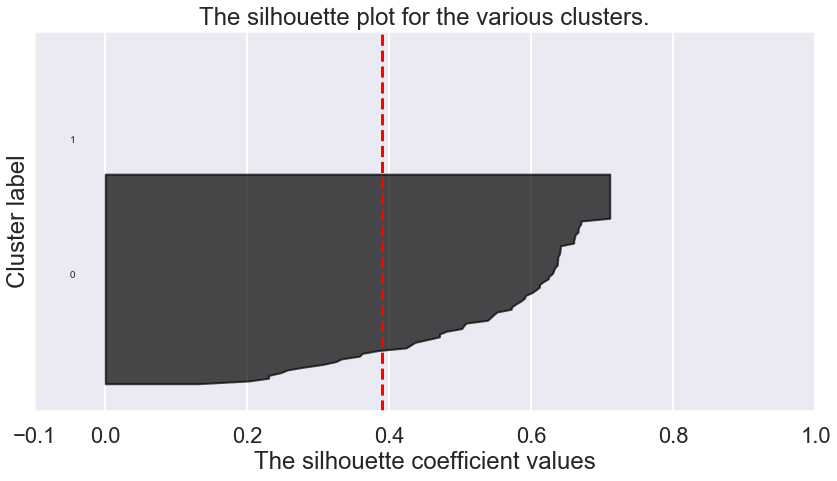

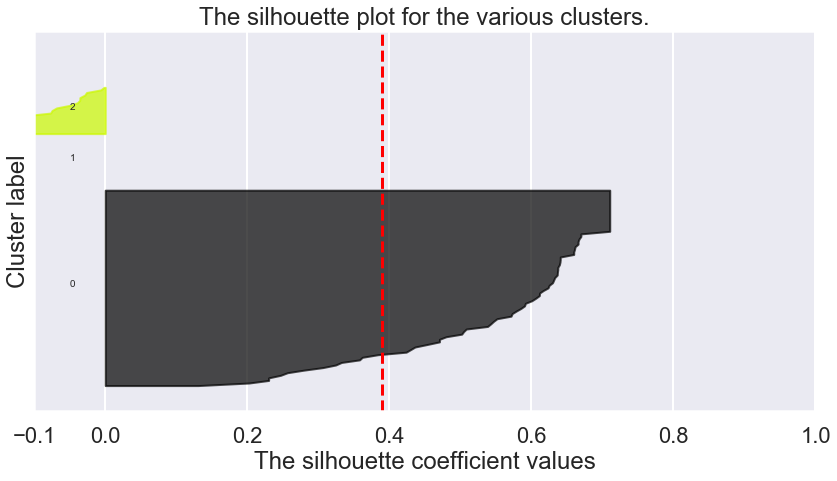

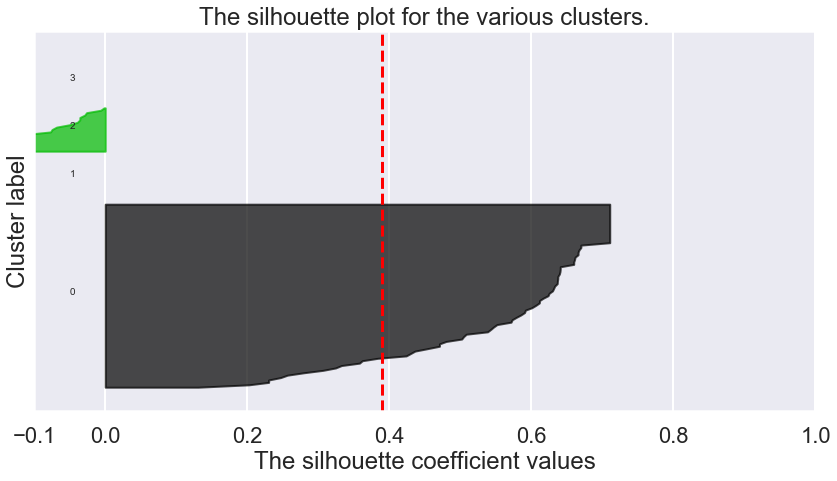

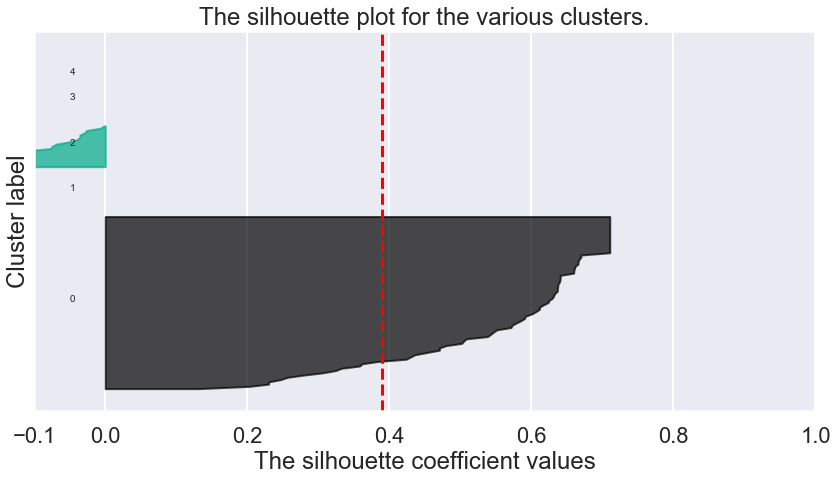

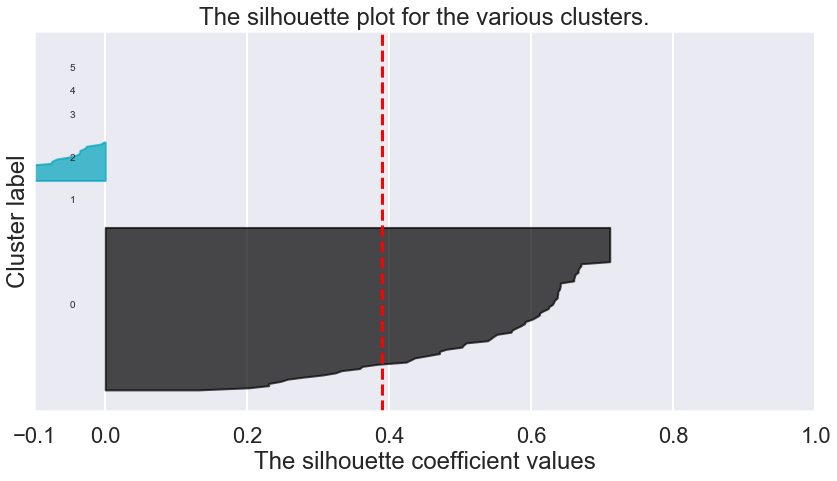

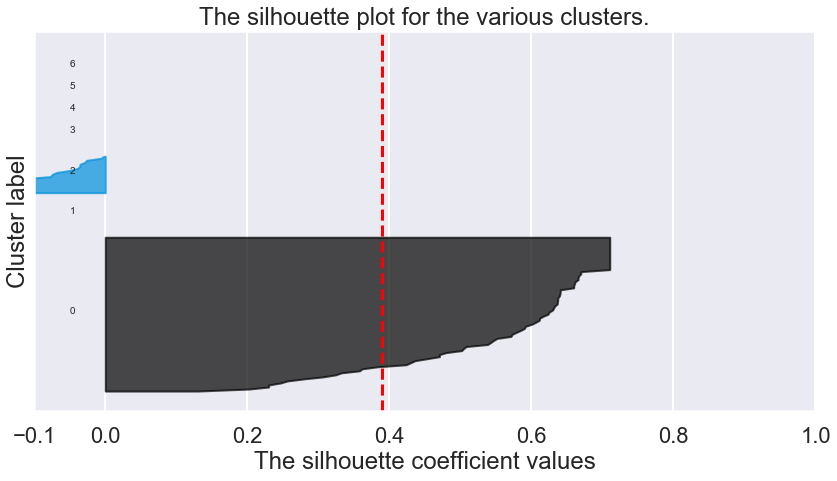

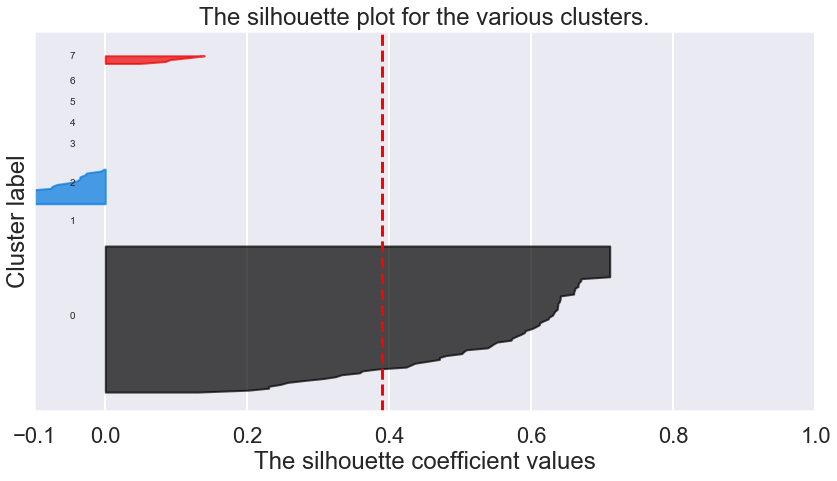

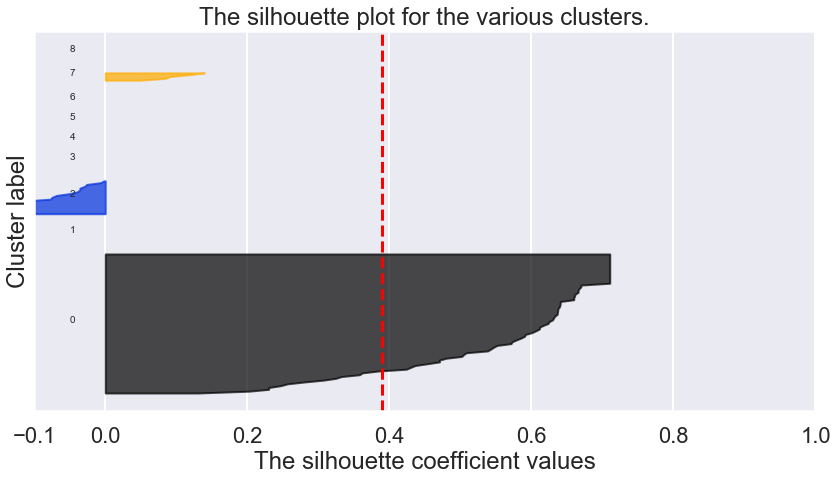

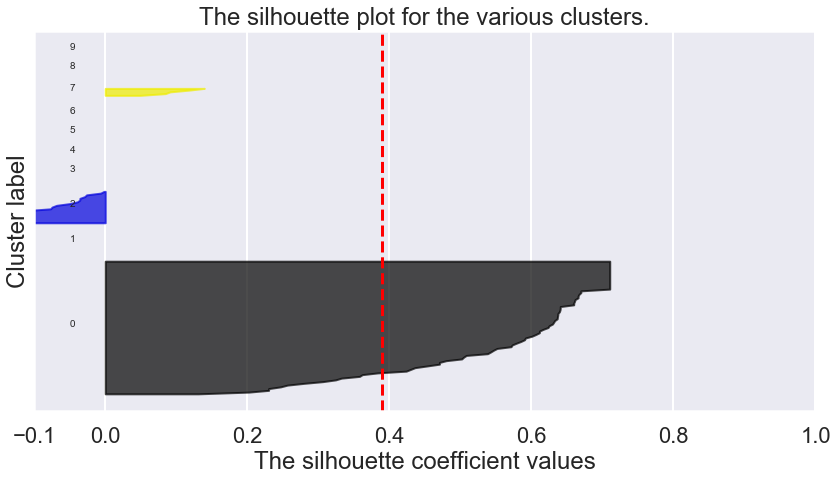

In [755]:
range_n_clusters2 = np.arange(2,11)
silhouette_scores2 = []

for n_clusters in range_n_clusters:
    #Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(14,7)
    
    #1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    
    #Initialize the cluster with n_clusters value and random state of 10
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels2 = clusterer.fit_predict(x_cols2)
    
    #Average value for all samples through silhouette_score
    sil_avg2 = silhouette_score(x_cols2, cluster_labels2)
    silhouette_scores2.append(sil_avg2)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette score is :", sil_avg2)
    
    #Silhouette score of each sample
    sample_silhouette_values2 = silhouette_samples(x_cols2, cluster_labels2)
    
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        # Sort scores for samples of cluster i 
        ith_cluster_silhouette_values.sort()
        
        # Obtain shape to add with y_lower scaling for y
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
     # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

plt.show()

Text(0.5, 1.0, 'Average Silhouette Scores for $k$')

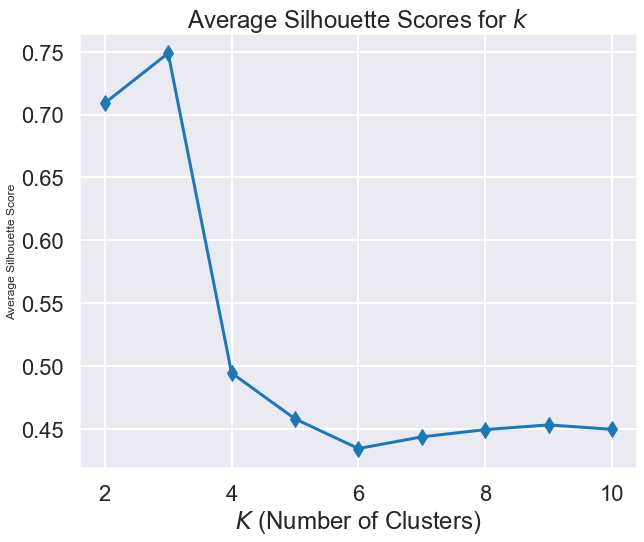

In [756]:
# Plot the Silhouette score for k = 2-10 clusters
plt.figure(figsize=(10,8))
plt.plot(range_n_clusters2,silhouette_scores2, marker='d')
plt.xlabel('$K$ (Number of Clusters)')
plt.ylabel('Average Silhouette Score', size = 12)
plt.title('Average Silhouette Scores for $k$')

Silhouette method suggests that the $K$ value of 3 is the best value to choose since it has the highest score at 0.75.

## Visualizing Clusters using PCA

In [759]:
#Create merged DataFrame
df_main2 = pd.merge(df_merge2, df_pca2, on='Specialty')
df_main2.sort_values('Cluster_2').head()

,NPI,Specialty,Spec_group,N,Abbrev,Region,Opioid_Prescriber,Population,Gender,NonOpi,Cluster_1,Cluster_2,x,y
24758,1720095482,Unknown Supplier/Provider,group4,1,ND,Central,1,723393,M,252,0,0,-2.003162,1.001359
17626,1063470250,Dermatology,group1,1,AL,South,0,4833722,F,494,4,0,0.224853,-1.648549
17627,1356639934,Dermatology,group1,1,NY,North East,0,19651127,F,61,4,0,0.224853,-1.648549
17628,1609956598,Dermatology,group1,1,NY,North East,0,19651127,M,44,4,0,0.224853,-1.648549
17629,1215014683,Dermatology,group1,1,NY,North East,0,19651127,F,11,4,0,0.224853,-1.648549


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

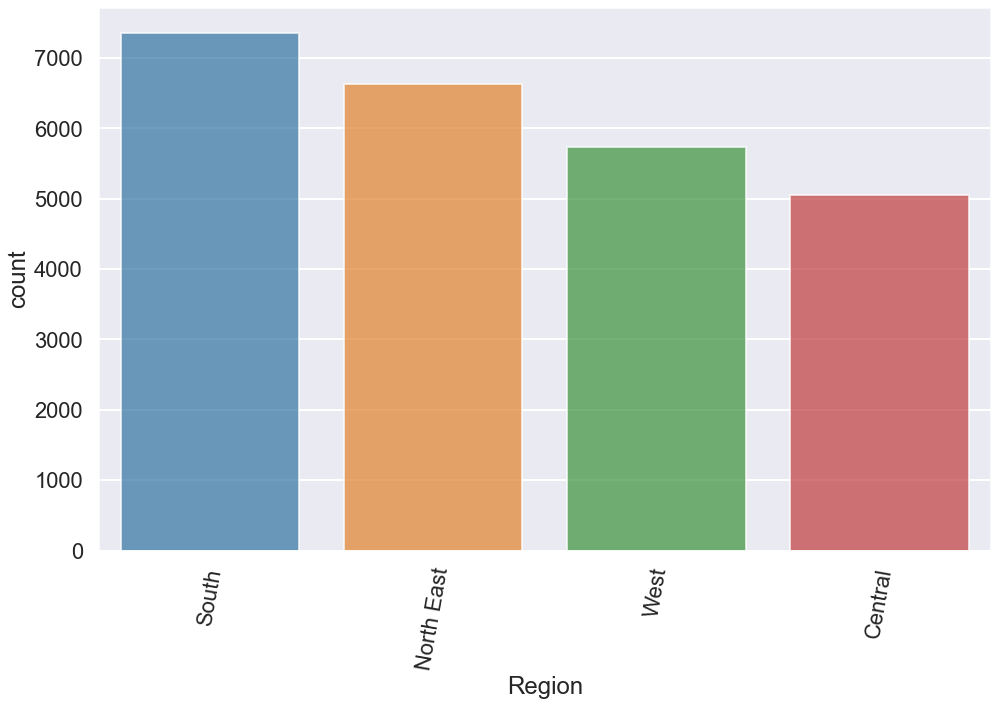

In [760]:
plt.figure(figsize=(16,10))
sns.countplot(x='Region',data=df_main2,alpha=0.7)
plt.xticks(rotation=80)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

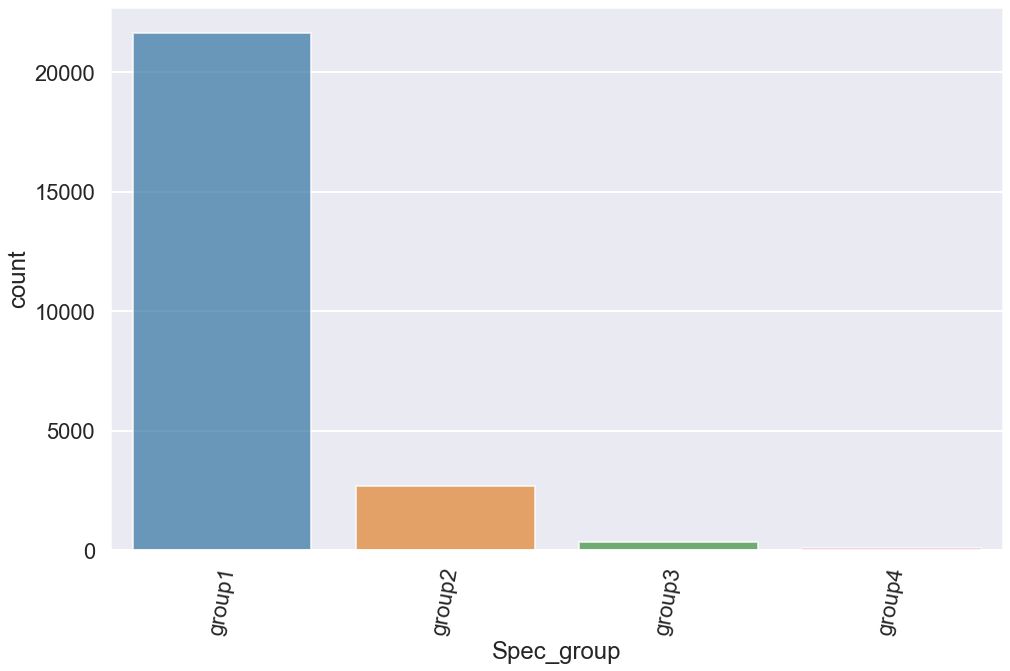

In [761]:
plt.figure(figsize=(16,10))
sns.countplot(x='Spec_group',data=df_main2,alpha=0.7)
plt.xticks(rotation=80)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

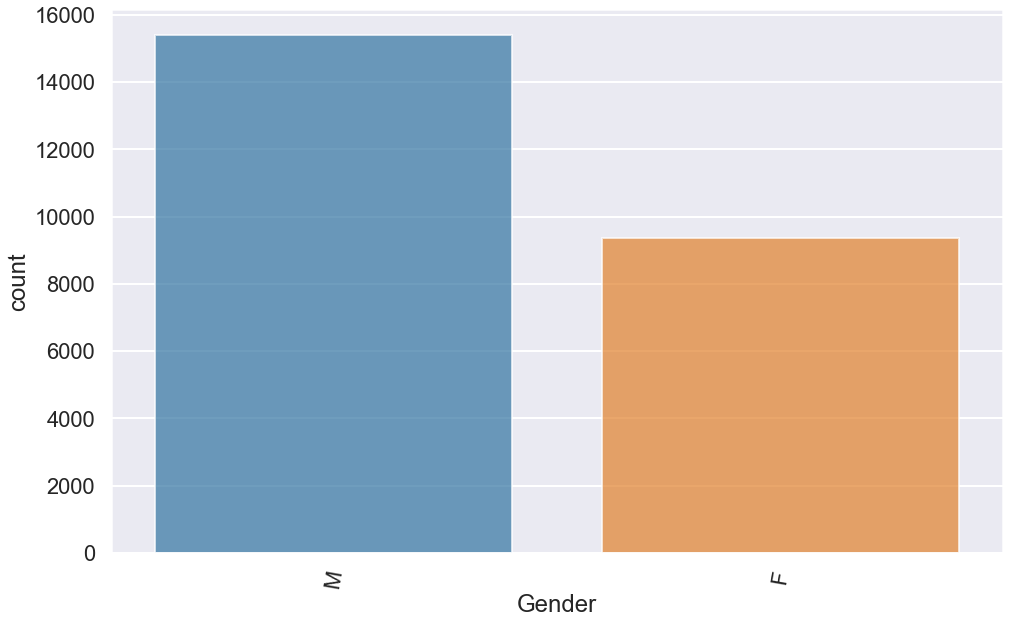

In [762]:
plt.figure(figsize=(16,10))
sns.countplot(x='Gender', data=df_main2,alpha=0.7)
plt.xticks(rotation=80)

[]

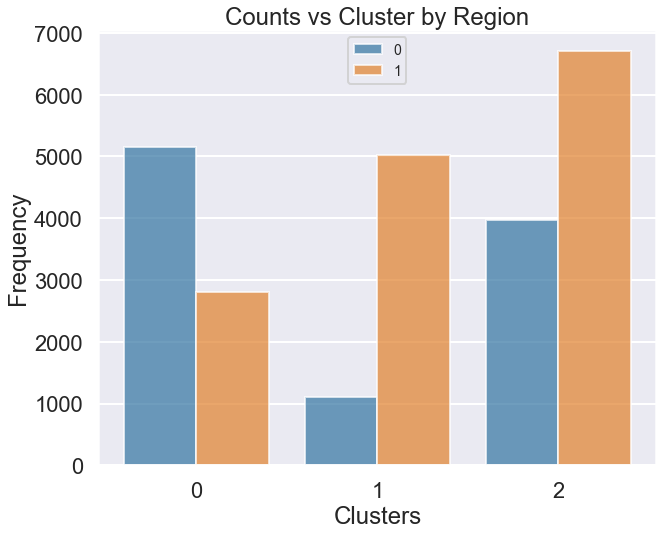

In [763]:
clust_group21 = df_main2.groupby(['Cluster_2', 'Opioid_Prescriber']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group21, hue='Opioid_Prescriber', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Region')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

[]

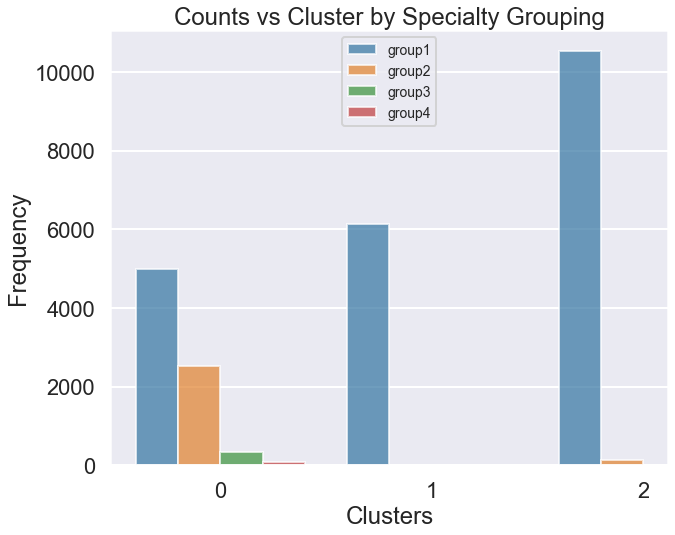

In [764]:
clust_group22 = df_main2.groupby(['Cluster_2', 'Spec_group']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group22, hue='Spec_group', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Specialty Grouping')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

[]

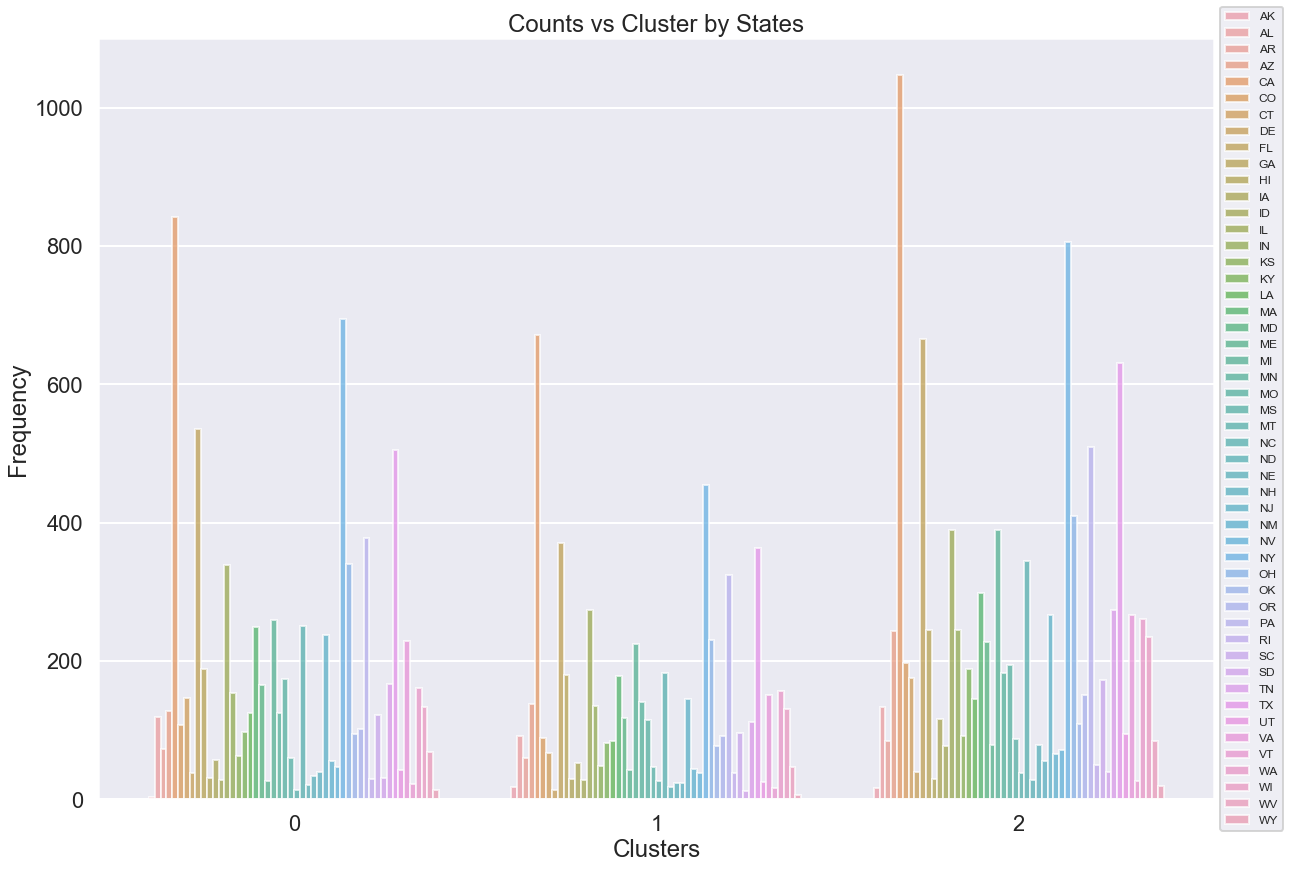

In [765]:
clust_group23 = df_main2.groupby(['Cluster_2', 'Abbrev']).Specialty.count().reset_index()

plt.figure(figsize=(20,14))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group23, hue='Abbrev', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by States')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.plot()

Each cluster seemed to have a have the same components leading the clusters. Group1 for Specialties is mostly made up of the specialsts who have higher opioid prescriptions given. In regards to the states, the states with the higher populations seem to be leading the way in the various clusters as well.

(0, 10)

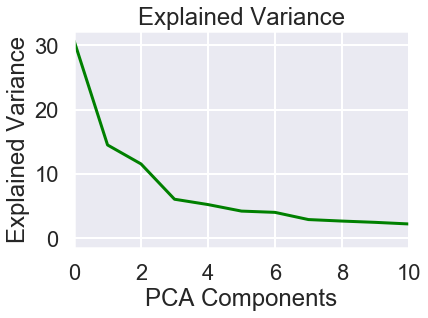

In [766]:
# Initialize a new PCA model with a default number of components.
pca2 = sklearn.decomposition.PCA()
pca2.fit(x_cols2)

# Do the rest on your own :)
plt.plot(pca2.explained_variance_, c='g', linewidth=3)
plt.title('Explained Variance')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance')
plt.xlim([0, 10])

The elbow curve looks to be at 1

### Other Clustering Algorithms

In [846]:
algorithms2 = ['AffinityPropagation2', 'SpectralClustering2', 'AgglomerativeClustering2', 'DBSCAN2']
algorithm_silscores2 = pd.Series(index=algorithms2)

In [847]:
#Affinity Propagation (x_cols2)

#find the best value for damping parameter. 
dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0.0
for damping in dampings:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(x_cols2)
    silhouette_avg = silhouette_score(x_cols2, labels, random_state=10)
    print("For damping =", damping,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_damping = damping
        
print('Best damping parameter:', best_damping)
algorithm_silscores2.loc['AffinityPropagation2'] = best_score

For damping = 0.5 The average silhouette_score is : 0.3639348336445824
For damping = 0.6 The average silhouette_score is : 0.36129127526579585
For damping = 0.7 The average silhouette_score is : 0.36129127526579585
For damping = 0.8 The average silhouette_score is : -9.779002225371128e-05
For damping = 0.9 The average silhouette_score is : -9.779002225371128e-05
Best damping parameter: 0.5


In [849]:
#Spectral Clustering (x_cols2)

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols2)
    silhouette_avg = silhouette_score(x_cols2, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores2.loc['SpectralClustering2'] = best_score

C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 2 The average silhouette_score is : 0.5929097196557072
For n_clusters = 3 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 4 The average silhouette_score is : 0.5713631763384777
For n_clusters = 5 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 6 The average silhouette_score is : 0.5713631763384777
For n_clusters = 7 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 8 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  n_init=n_init)


For n_clusters = 9 The average silhouette_score is : 0.5713631763384777
For n_clusters = 10 The average silhouette_score is : 0.5713631763384777
Best n_clusters parameter: 2


In [852]:
#Agglomerative Clustering (x_cols2)

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols2)
    silhouette_avg = silhouette_score(x_cols2, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores2.loc['AgglomerativeClustering2'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.750628348136885
For n_clusters = 3 The average silhouette_score is : 0.7488355496134914
For n_clusters = 4 The average silhouette_score is : 0.48022392116076246
For n_clusters = 5 The average silhouette_score is : 0.4721916922564833
For n_clusters = 6 The average silhouette_score is : 0.4692417392909587
For n_clusters = 7 The average silhouette_score is : 0.46170175401010066
For n_clusters = 8 The average silhouette_score is : 0.45678828309103714
For n_clusters = 9 The average silhouette_score is : 0.4417503388704778
For n_clusters = 10 The average silhouette_score is : 0.443612780026244
Best n_clusters parameter: 2


In [928]:
#DBSCAN (x_cols2)

#find the best value for min_samples parameter. 
range_min_samples = [1, 2]
best_score = 0.0
for min_samples in range_min_samples:
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols2)
    silhouette_avg = silhouette_score(x_cols2, labels, random_state=10)
    print("For min_samples =", min_samples,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_min_samples = min_samples
        
print('Best min_samples parameter:',best_min_samples)
algorithm_silscores2.loc['DBSCAN2'] = best_score

For min_samples = 1 The average silhouette_score is : 0.037037037037037035
For min_samples = 2 The average silhouette_score is : -0.41754558235017175
Best min_samples parameter: 1


In [927]:
print(algorithm_silscores2)

AffinityPropagation2        0.363935
SpectralClustering2         0.592910
AgglomerativeClustering2    0.750628
DBSCAN2                     0.037037
dtype: float64


The clustering algorithms offer different results with Agglomerative Clustering offering the highest silhouette score. None of the scores offer high enough scores though. More features would be needed to raise the scores higher.